<a href="https://colab.research.google.com/github/fboasorte/TopicosIC/blob/master/Etapa2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# - Pandas
import pandas as pd
# - numpy
import numpy as np
# - seaborn
import seaborn as sb

# - sklearn
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
# - tensorflow
import tensorflow as tf
# - Matplotlib
import matplotlib.pyplot as plt

import warnings

sb.set_style("dark")
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['survey_results_public.csv']))
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,EUR,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",White or of European descent,Man,"Languages, frameworks, and other technologies ...",Slightly satisfied,I am not interested in new job opportunities,C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,.NET Core;Xamarin,.NET;.NET Core,Microsoft Teams;Microsoft Azure;Trello,Confluence;Jira;Slack;Microsoft Azure;Trello,No,Somewhat important,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,Often: 1-2 days per week or more,Start a free trial;Ask developers I know/work ...,Amused,Stack Overflow (public Q&A for anyone who codes),Visit Stack Overflow;Go for a walk or other ph...,Windows,2 to 9 employees,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows,NaN,Straight / Heterosexual,No,"No, not at all",NaN,Multiple times per day,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,GBP,NaN,NaN,"Developer, full-stack;Developer, mobile","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,NaN,NaN,NaN,Very dissatisfied,I am not interested in new job opportunities,Python;Swift,JavaScript;Swift,React Native;TensorFlow;Unity 3D,React Native,Github;Slack,Confluence;Jira;Github;Gitlab;Slack,NaN,NaN,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,NaN,NaN,Amused,Stack Overflow (public Q&A for anyone who code...,Visit Stack Overflow;Go for a walk or other ph...,MacOS,"1,000 to 4,999 employees",iOS;Kubernetes;Linux;MacOS,iOS,I have little or no influence,NaN,Yes,"Yes, definitely",Less than once per month or monthly,Multiple times per day,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Objective-C;Python;Swift,Objective-C;Python;Swift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Once a decade,NaN,NaN,No,NaN,NaN,NaN,Stack Overflow (public Q&A for anyone who codes),NaN,Linux-based,NaN,NaN,NaN,NaN,NaN,Yes,"Yes, somewhat",A few times per month or weekly,Daily or almost daily,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,ALL,NaN,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,White or of European descent,Man,Flex time or a flexible schedule;Office enviro...,Slightly dissatisfied,"I’m not actively looking, but I am open to new...",NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,Not at all important/not necessary,Curious about other opportunities;Wanting to w...,NaN,Once a year,Not sure,Yes,Yes,Occasionally: 1-2 days per quarter but less th...,NaN,NaN,Stack Overflow (public Q&A for anyone who code...,NaN,Lin

In [ ]:
data = df.query('MainBranch == "I am a developer by profession"')

In [ ]:
columns = ['JobSat','Country','YearsCode', 'Age1stCode', 'EdLevel', 'DevType', 'JobSeek', 'MiscTechWorkedWith', 'LanguageWorkedWith', 'OpSys', 'Age', 'ConvertedComp',
           'Hobbyist', 'MainBranch', 'YearsCodePro', 'WebframeWorkedWith', 'UndergradMajor', 'PurchaseWhat', 'PlatformWorkedWith', 'OrgSize',
           'NEWStuck', 'NEWEdImpt', 'JobFactors', 'Employment','DatabaseWorkedWith']

data = data[columns]


In [ ]:
data = data.dropna()

In [ ]:
# Funcoes necessarias para trabahar com os dados
def onehot_encode(df, columns):
    df = df.copy()
    for column in columns:
        dummies = pd.get_dummies(df[column])
        df = pd.concat([df, dummies], axis = 1)
        df = df.drop(column, axis = 1)
    return df

def onehot_encode_semicolon(df, columns):
    df = df.copy()
    skills = [[] for _ in range(len(df.index))]
    new_columns = []
    for column in columns:
        sp = df[column].str.split(';')
        for row, linha in zip(sp, np.arange(len(sp))):
            for item in row:
                if item not in new_columns:
                    new_columns.append(item)
            skills[linha].append(item)
        df = df.drop(column, axis = 1)
                    
    new_values = [
    [0 for _ in range(len(new_columns))] for _ in range(len(df.index)) 
    ]
    
    temp = pd.DataFrame(data = new_values , columns = new_columns, index = df.index)  
    
    for ans, i  in zip(skills, np.arange(len(skills))):
        temp.loc[i, ans] = 1

    df = pd.concat([df, temp], axis = 1)

    return df
    
    
def label_encoder(df, columns):
    df = df.copy()
    
    labels_enc = [LabelEncoder() for _ in range(len(columns))]
    for column, le in zip(columns, labels_enc):
        le.fit(df[column])
        col = pd.DataFrame(data=le.transform(df[column]), columns=[column])

        df = df.drop(column, axis = 1)
        df = pd.concat([df, col], axis = 1)
    return df


In [ ]:
data = data.reset_index(drop=True)

In [ ]:
semicolon = []
others = []
for column in data:
    if data.dtypes[column] == 'object':  
        c = False
        if True in data[column].str.contains(';').values:
            semicolon.append(column)
        else:
            others.append(column) 

In [ ]:
data = label_encoder(data, others)
data

,DevType,MiscTechWorkedWith,LanguageWorkedWith,Age,ConvertedComp,WebframeWorkedWith,PlatformWorkedWith,NEWStuck,JobFactors,DatabaseWorkedWith,JobSat,Country,YearsCode,Age1stCode,EdLevel,JobSeek,OpSys,Hobbyist,MainBranch,YearsCodePro,UndergradMajor,PurchaseWhat,OrgSize,NEWEdImpt,Employment
0,"Developer, back-end;Developer, desktop or ente...",Ansible,Python;SQL,36.0,116000.0,Flask,Docker,Play games;Call a coworker or friend;Visit Sta...,Remote work options;Opportunities for professi...,MariaDB;MySQL;Redis,1,136,8,2,1,2,1,1,0,4,6,2,5,2,0
1,"Database administrator;Developer, full-stack;D...",Pandas,HTML/CSS;Java;JavaScript;Python;SQL,22.0,32315.0,Flask;jQuery,Android;Linux;Raspberry Pi;Windows,Visit Stack Overflow,Flex time or a flexible schedule;How widely us...,Microsoft SQL Server,4,134,47,4,2,2,3,1,0,33,10,0,4,1,0
2,"Developer, back-end;Developer, desktop or ente...",Node.js,C#;JavaScript;Swift,23.0,40070.0,Angular;Angular.js;Django;React.js,AWS;Heroku;iOS,Play games;Call a coworker or friend;Visit Sta...,"Flex time or a flexible schedule;Languages, fr...",Firebase;MongoDB;PostgreSQL;SQLite,1,134,1,3,1,0,3,1,0,11,6,1,2,4,0
3,"Developer, desktop or enterprise applications;...",Node.js,HTML/CSS;JavaScript;SQL;TypeScript,27.0,66000.0,Angular;Vue.js,Google Cloud Platform;Windows,Call a coworker or friend;Visit Stack Overflow...,Industry that I’d be working in;Flex time or a...,Firebase;Microsoft SQL Server,2,136,44,3,0,2,3,1,0,0,6,1,3,3,0
4,"Developer, full-stack",.NET;.NET Core;Node.js,Bash/Shell/PowerShell;C#;HTML/CSS;JavaScript;S...,24.0,83400.0,Angular;Angular.js;ASP.NET Core,Windows,Call a coworker or friend;Visit Stack Overflow...,Flex time or a flexible schedule;Office enviro...,MariaDB;Microsoft SQL Server,1,136,48,5,1,2,3,0,0,22,6,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13188,DevOps specialist,Ansible;Node.js;Teraform,Bash/Shell/PowerShell;Go;HTML/CSS;JavaScript;SQL,30.0,1000000.0,Express,AWS;Docker;Google Cloud Platform;Kubernetes;Li...,Visit Stack Overflow;Go for a walk or other ph...,Industry that I’d be working in;Specific depar...,Elasticsearch;MongoDB;MySQL;PostgreSQL;Redis,1,22,47,9,0,2,1,1,0,33,6,2,0,0,0
13189,"Developer, full-stack",.NET,C#;HTML/CSS;JavaScript;SQL,30.0,38724.0,ASP.NET;jQuery,Windows,Call a coworker or friend;Visit Stack Overflow...,"Languages, frameworks, and other technologies ...",Microsoft SQL Server,2,112,22,11,1,2,3,1,0,40,5,1,2,3,0
13190,"Database administrator;Developer, back-end;Dev...",.NET Core;Node.js,Bash/Shell/PowerShell;C#;HTML/CSS;JavaScript;P...,32.0,74500.0,Angular;ASP.NET Core;Django;jQuery,Linux;MacOS,Play games;Call a coworker or friend;Visit Sta...,"Flex time or a flexible schedule;Languages, fr...",MariaDB;Microsoft SQL Server;MySQL,2,136,10,2,5,2,1,1,0,43,6,2,1,2,0
13191,"Developer, back-end;DevOps specialist",Pandas,Assembly;C;C++;HTML/CSS;Java;JavaScript;PHP;Py...,33.0,59454.0,Django;Flask;jQuery;Ruby on Rails,Docker;Linux,Call a coworker or friend;Visit Stack Overflow...,Flex time or a flexible schedule;Office enviro...,DynamoDB;Elasticsearch;MongoDB;MySQL;Oracle;Po...,4,41,12,3,4,1,2,0,0,3,6,2,3,1,0


In [ ]:
data = onehot_encode_semicolon(data, semicolon)
data

,Age,ConvertedComp,JobSat,Country,YearsCode,Age1stCode,EdLevel,JobSeek,OpSys,Hobbyist,MainBranch,YearsCodePro,UndergradMajor,PurchaseWhat,OrgSize,NEWEdImpt,Employment,"Developer, back-end","Developer, desktop or enterprise applications","Developer, game or graphics",Database administrator,"Developer, full-stack","Developer, mobile","Developer, embedded applications or devices","Developer, front-end",Engineering manager,DevOps specialist,Data scientist or machine learning specialist,"Developer, QA or test","Engineer, data",Scientist,Data or business analyst,System administrator,Designer,Educator,"Engineer, site reliability",Product manager,Academic researcher,Senior executive/VP,Marketing or sales professional,...,MacOS,Slack Apps and Integrations,Arduino,Microsoft Azure,WordPress,IBM Cloud or Watson,Play games,Call a coworker or friend,Visit Stack Overflow,Go for a walk or other physical activity,Watch help / tutorial videos,Do other work and come back later,Panic,Meditate,Visit another developer community (please name):,Remote work options,Opportunities for professional development,Family friendliness,Flex time or a flexible schedule,How widely used or impactful my work output would be,"Languages, frameworks, and other technologies I’d be working with",Industry that I’d be working in,Office environment or company culture,Diversity of the company or organization,Specific department or team I’d be working on,Financial performance or funding status of the company or organization,MariaDB,MySQL,Redis,Microsoft SQL Server,Firebase,MongoDB,PostgreSQL,SQLite,Oracle,Elasticsearch,Cassandra,DynamoDB,Couchbase,IBM DB2
0,36.0,116000.0,1,136,8,2,1,2,1,1,0,4,6,2,5,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,22.0,32315.0,4,134,47,4,2,2,3,1,0,33,10,0,4,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,23.0,40070.0,1,134,1,3,1,0,3,1,0,11,6,1,2,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,27.0,66000.0,2,136,44,3,0,2,3,1,0,0,6,1,3,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,24.0,83400.0,1,136,48,5,1,2,3,0,0,22,6,1,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13188,30.0,1000000.0,1,22,47,9,0,2,1,1,0,33,6,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
13189,30.0,38724.0,2,112,22,11,1,2,3,1,0,40,5,1,2,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
13190,32.0,74500.0,2,136,10,2,5,2,1,1,0,43,6,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
13191,33.0,59454.0,4,41,12,3,4,1,2,0,0,3,6,2,3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
columns = ['JobSat','Country','YearsCode', 'Age1stCode', 'EdLevel', 'DevType', 'JobSeek', 'MiscTechWorkedWith', 'LanguageWorkedWith', 'OpSys', 'Age', 'ConvertedComp',
           'Hobbyist', 'MainBranch', 'YearsCodePro', 'WebframeWorkedWith', 'UndergradMajor', 'PurchaseWhat', 'PlatformWorkedWith', 'OrgSize',
           'NEWStuck', 'NEWEdImpt', 'JobFactors', 'Employment','DatabaseWorkedWith']


from sklearn import linear_model
regr = linear_model.LinearRegression()

X = data['JobSat']
y = data['Age1stCode']

X = X.values
y = y.values

#Para criar o modelo irei usar todos os dados, exceto os últimos 20 registros, da coluna age (idade)

X_treinamento = X[:-20].reshape(-1,1)
#Para validar o modelo, usei os 20 últimos registros
X_teste = X[-20:].reshape(-1,1)

#mesma coisa aqui, porém, para o target (coluna y)
y_treinamento = y[:-20]
y_teste = y[-20:].reshape(-1,1)

#cria o modelo de regressão linear
regr = linear_model.LinearRegression()

# treina o modelo com os dados treinamento
regr.fit(X_treinamento, y_treinamento)

#coeficientes b1
print('Coeficiente b1: \n', regr.coef_)
#intercepto b0
print('Coeficiente b0: \n', regr.intercept_)

Coeficiente b1: 
 [0.09081192]
Coeficiente b0: 
 8.245507537647523


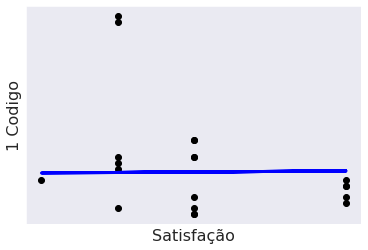

In [77]:
# Predição/validação
diabetes_y_pred = regr.predict(X_teste)
#plota os dados reais
plt.scatter(X_teste,y_teste,  color='black')
# plota os dados preditos
plt.plot(X_teste, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())
plt.xlabel("Satisfação", size = 16,)
plt.ylabel("1 Codigo", size = 16)
plt.show()

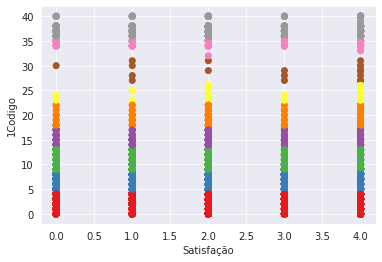

In [78]:
plt.subplots()
plt.scatter(X, y, c=y, cmap=plt.cm.Set1)
plt.xlabel('Satisfação')
plt.ylabel('1Codigo')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.neural_network import MLPClassifier
import numpy
clf = MLPClassifier(alpha=0.01,max_iter=2000)
#dados de treinamento 'até 40' de cada classe
yt=numpy.concatenate([y[:40], y[51:90], y[101:140]])
xt = numpy.concatenate([X[:40], X[51:90], X[101:140]])
xt = xt.reshape(-1,1)
yt = yt.reshape(-1,1)
clf.fit(xt, yt)  
#validacão com o restante dos dados
yv=numpy.concatenate([y[40:50], y[90:100], y[140:150]])
xv = numpy.concatenate([X[40:50], X[90:100], X[140:150]])
xv = xv.reshape(-1,1)
yp=clf.predict(xv)
print(yp)
print(yv)

[3 4 3 4 9 4 5 9 3 4 3 3 4 4 3 5 4 5 4 3 4 3 3 4 3 5 4 3 5 4]
[ 8 37  4  2  5  7  2  2  6  1  4 31  4  4  8  5  8  6  1  5  2  2  0  2
  7  0 34  5  0  1]


In [ ]:
from collections import Counter
comp = yp == yv
c= Counter(comp)
print(c)
#taxa de acerto
print(c[1]/(c[0]+c[1]))

Counter({False: 27, True: 3})
0.1


Matriz de confusão, sem normalizar
[[0 0 0 1 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 1 3 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 2 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 1 0 0 0 1 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 2 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0]]
Matriz de confusão normalizada
[[0.         0.         0.         0.33333333 0.         0.66666667
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.16666667 0.5        0.16666667
  0.         0.         0.         0.16666667 0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.

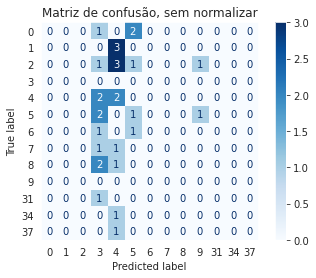

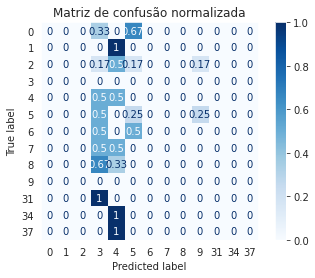

In [ ]:
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Matriz de confusão, sem normalizar", None),
                  ("Matriz de confusão normalizada", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, xv, yv,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()